<a href="https://www.kaggle.com/code/clemwo/understanding-trees-in-depth?scriptVersionId=196421876" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install dash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 28.4 MB/s eta 0:00:00


In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from dash import Dash, html, dcc, callback, Output, Input

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification, load_iris, load_wine, load_diabetes
from sklearn.metrics import auc

import lightgbm
import xgboost
import xgboost as xgb
        
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

/kaggle/input/drug-classification/drug200.csv


# 🤔Understanding Trees 🌳 In Depth💡

In this notebook we are going to investigate trained machine learning trees and their predictions in depth. For that matter we will use [Kaggle's Drug Classification](https://www.kaggle.com/datasets/prathamtripathi/drug-classification/data) dataset.

The dataset contains the following columns: 

| Column | Description | 
|:-------|:------------|
| `Age` | Age of the patient |
| `Sex` | Gender of the patient |
| `BP` | Blood pressure levels |
| `Cholesterol` | Cholesterol levels |
| `Na_to_K` | Sodium to potassium ratio in blood |
| `Drug` | Drug type |

In [3]:
drugs = pd.read_csv('/kaggle/input/drug-classification/drug200.csv')
print(f"Rows: {drugs.shape[0]:,}")
print(f"Cols: {drugs.shape[1]:,}")
drugs.head(3)

Rows: 200
Cols: 6


,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC


# Global Settings

In [4]:
RANDOM_STATE = 42

# Pre-Processing

In [5]:
features = ['Age', 'Na_to_K']
target = None

In [6]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
categorical_columns = drugs.select_dtypes(include=['object']).columns

for col in categorical_columns:
    encoded_col_name = col + '_Encoded'
    drugs[encoded_col_name] = label_encoder.fit_transform(drugs[col])
    
    if 'Drug' not in encoded_col_name:
        features.append(encoded_col_name)
    else:
        target = encoded_col_name

print(f"Modelling features: {features}")
print(f"Modelling target  : {target}")
drugs.head(3)

Modelling features: ['Age', 'Na_to_K', 'Sex_Encoded', 'BP_Encoded', 'Cholesterol_Encoded']
Modelling target  : Drug_Encoded


,Age,Sex,BP,Cholesterol,Na_to_K,Drug,Sex_Encoded,BP_Encoded,Cholesterol_Encoded,Drug_Encoded
0,23,F,HIGH,HIGH,25.355,DrugY,0,0,0,0
1,47,M,LOW,HIGH,13.093,drugC,1,1,0,3
2,47,M,LOW,HIGH,10.114,drugC,1,1,0,3


In [7]:
drugs['Drug_Encoded'].value_counts()

Drug_Encoded
0    91
4    54
1    23
3    16
2    16
Name: count, dtype: int64

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(drugs[features], 
                                                    drugs[target], 
                                                    test_size=0.2, 
                                                    random_state=RANDOM_STATE)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (160, 5)
X_test shape: (40, 5)
y_train shape: (160,)
y_test shape: (40,)


In [9]:
xgb_params = {
    'max_depth': 3,                # maximum depth of each tree
    'eta': 0.3,                    # training step for each iteration
    'objective': 'multi:softprob',
    'eval_metric': 'mlogloss',     # error evaluation for multiclass training
    'num_class': 5
}
num_round = 100
xgb_train = xgb.DMatrix(X_train, label = y_train, enable_categorical = False)
xgb_test = xgb.DMatrix(X_test, label = y_test, enable_categorical = False)

xgb_evals_result = {}
xgb_clf = xgb.train(xgb_params,
                    xgb_train, 
                    num_round, 
                    evals=[
                        (xgb_train, 'training') , 
                        (xgb_test, 'valid')
                    ], 
                    evals_result = xgb_evals_result)

[0]	training-mlogloss:1.04337	valid-mlogloss:1.10859
[1]	training-mlogloss:0.75492	valid-mlogloss:0.82417
[2]	training-mlogloss:0.56781	valid-mlogloss:0.64859
[3]	training-mlogloss:0.43791	valid-mlogloss:0.52975
[4]	training-mlogloss:0.33362	valid-mlogloss:0.42209
[5]	training-mlogloss:0.26289	valid-mlogloss:0.34346
[6]	training-mlogloss:0.20470	valid-mlogloss:0.28226
[7]	training-mlogloss:0.15942	valid-mlogloss:0.22560
[8]	training-mlogloss:0.12674	valid-mlogloss:0.19071
[9]	training-mlogloss:0.10159	valid-mlogloss:0.15636
[10]	training-mlogloss:0.08279	valid-mlogloss:0.13064
[11]	training-mlogloss:0.06861	valid-mlogloss:0.11463
[12]	training-mlogloss:0.05786	valid-mlogloss:0.09906
[13]	training-mlogloss:0.05015	valid-mlogloss:0.09140
[14]	training-mlogloss:0.04396	valid-mlogloss:0.08328
[15]	training-mlogloss:0.03921	valid-mlogloss:0.07778
[16]	training-mlogloss:0.03528	valid-mlogloss:0.07250
[17]	training-mlogloss:0.03206	valid-mlogloss:0.06781
[18]	training-mlogloss:0.02952	valid-m

# Model Complexity Tool

In [10]:
class BoostingComplexityAnalyzer:
    def __init__(self, model, classification_mode, metric_key, evals_result, n_classes = 2):
        self.model = model
        self.classification_mode = classification_mode
        self.n_classes = n_classes
        self.tree_details = None
        self.tree_depths = None
        self.cover_by_tree_index = None
        self.feature_gain_by_tree_index = None
        self.feature_thresholds_by_index = None
        self.tree_threshold_details = None
        self.unique_features = None
        self.tree_features = None
        self.metric_key = metric_key
        self.evals_result = evals_result
        self.learning_curves = None
        

    def fit(self):
        self._validate_inputs()
        self._extract_tree_details()
        self._calculate_tree_depths()
        self._compute_model_gain()
        self._compute_gain_attribution_by_feature()
        self._calculate_unique_splits()
        self._compute_min_max_threshold_analysis()
        self._compute_model_cover_attributions()
        self._compute_feature_usage_greediness_metric()

        if (self.metric_key and self.evals_result) is not None:
            self._compute_learning_curves()

    def _validate_inputs(self):
        """
        Validates the inputs to the class.

        Checks that the model is an instance of either `lightgbm.sklearn.LGBMClassifier`, `lightgbm.basic.Booster`, or `xgboost.core.Booster`. 
        It also checks that the `classification_mode` is either 'binary' or 'multi'. 
        If the `classification_mode` is 'multi', it further checks that `n_classes` is greater than 2.
        """
        assert type(self.model) in [
            lightgbm.sklearn.LGBMClassifier,
            lightgbm.basic.Booster,
            xgboost.core.Booster,
        ], "The input model must be either lightgbm.sklearn.LGBMClassifier or lightgbm.basic.Booster. XGBoost is not supported yet."

        assert self.classification_mode in [
            "binary",
            "multi",
        ], "classification_mode must be either 'binary' or 'multi'."

        if self.classification_mode == "multi":
            assert self.n_classes > 2, "Must provide n_classes > 2 for multi-class setting."

    def _extract_tree_details(self):
        """
        Extracts the details of each tree in the model and stores them in a DataFrame.

        This function checks the type of the model and calls the appropriate method to convert the model's trees to a DataFrame. 
        If the model is an XGBoost model, it renames the columns of the DataFrame to match the expected column names. 
        If the model is a multi-class classification model, it calculates the class and class tree index for each tree and adds these as new columns to the DataFrame.
        """
        if type(self.model) == lightgbm.sklearn.LGBMClassifier:
            self.tree_details = self.model.booster_.trees_to_dataframe()
        elif type(self.model) == lightgbm.basic.Booster:
            self.tree_details = self.model.trees_to_dataframe()
        if type(self.model) == xgboost.core.Booster:
            self.tree_details = self.model.trees_to_dataframe()

        print(self.tree_details.head())

        if type(self.model) in [xgboost.core.Booster]:
            self.tree_details = self.tree_details.rename(
                columns={
                    "Tree": "tree_index",
                    "Node": "node_depth",
                    "ID": "node_index",
                    "Feature": "split_feature",
                    "Split": "threshold",
                    "Gain": "split_gain",
                    "Cover": "count"
                }
            )

        if self.classification_mode == "multi":
            self.tree_details["tree_class"] = self.tree_details["tree_index"] % self.n_classes
            self.tree_details["class_tree_index"] = self.tree_details.groupby(["tree_class"])["tree_index"].rank(
                method = "dense"
            )

    def _calculate_tree_depths(self):
        """
        Calculates the depth of each tree in the model and computes various related metrics.

        Calculates the fraction of the total split gain that each split contributes. 
        It then calculates the maximum depth of each tree and the rolling average of the maximum depth over the last 5 trees. 
        If the 'split_feature_factorized' column does not exist in the tree details DataFrame, it factorizes the 'split_feature' column and adds the factorized values to the DataFrame. 
        It then computes the cumulative feature usage for each tree. 
        Finally, it calculates the total cover for each feature and tree index.
        """
        self.tree_details["frac_of_total_split_gain"] = self.tree_details.split_gain / self.tree_details.split_gain.sum()

        self.tree_depths = (
            self.tree_details.groupby("tree_index")["node_depth"]
            .max()
            .reset_index()
            .rename(columns = {"tree_index": "n_estimator", "node_depth": "max_node_depth"})
        )

        self.tree_depths["rolling_avg_max_depth"] = self.tree_depths["max_node_depth"].expanding(5).mean()

        if 'split_feature_factorized' not in self.tree_details.columns:
            self.tree_details['split_feature_factorized'], split_feature_encoding = pd.factorize(self.tree_details['split_feature'])
            split_feature_mapping = dict(enumerate(split_feature_encoding))

        self.tree_depths = self._compute_cumulative_feature_usage()
        self.cover = self.tree_details.groupby(['split_feature', 'tree_index'])['count'].sum().reset_index()
        self.leaf_analysis = self.tree_details[self.tree_details['split_feature'] == 'Leaf'].groupby(['tree_index'])['node_depth'].nunique().reset_index().rename(columns={'node_depth':'n_leaves_per_tree'})
        self.leaf_analysis['cumulative_leaves_in_model'] = self.leaf_analysis['n_leaves_per_tree'].cumsum()
        self.tree_depths = self.tree_depths.merge(self.leaf_analysis, how = 'left', left_on='n_estimator', right_on='tree_index')
        self.tree_depths['tree_depth_to_leaf_ratio'] = self.tree_depths['max_node_depth'] / self.tree_depths['n_leaves_per_tree']

    def _compute_model_cover_attributions(self):
        
        # Total Cover by Feature across entire model.
        self.cover_contribution = self.tree_details.groupby('split_feature')['count'].sum().sort_values(ascending = False).reset_index()
        self.median_cover = self.tree_details.groupby('split_feature')['count'].median().sort_values(ascending = False).reset_index()
        self.mean_cover = self.tree_details.groupby('split_feature')['count'].mean().sort_values(ascending = False).reset_index()
        self.std_dev_cover = self.tree_details.groupby('split_feature')['count'].std().sort_values(ascending = False).reset_index()

        n_features = self.cover_contribution.shape[0]

        # Compute Top N Features in Model by Cover from Sorted Index.
        self.cover_contribution = self.cover_contribution.reset_index().rename(columns = {'index':'top_n_features_in_model_by_cover'})
        self.cover_contribution['top_n_features_in_model_by_cover'] = self.cover_contribution['top_n_features_in_model_by_cover'] + 1

        self.median_cover = self.median_cover.reset_index().rename(columns = {'index':'top_n_features_in_model_by_median_cover'})
        self.median_cover['top_n_features_in_model_by_cover'] = self.median_cover['top_n_features_in_model_by_median_cover'] + 1

        self.mean_cover = self.mean_cover.reset_index().rename(columns = {'index':'top_n_features_in_model_by_mean_cover'})
        self.mean_cover['top_n_features_in_model_by_cover'] = self.mean_cover['top_n_features_in_model_by_mean_cover'] + 1

        self.std_dev_cover = self.std_dev_cover.reset_index().rename(columns = {'index':'top_n_features_in_model_by_std_dev_cover'})
        self.std_dev_cover['top_n_features_in_model_by_cover'] = self.std_dev_cover['top_n_features_in_model_by_std_dev_cover'] + 1

        # Compute Max Amount of Model Cover Seen.
        total_model_cover = self.cover_contribution['count'].cumsum().max()
        total_model_median_cover = self.median_cover['count'].cumsum().max()
        total_model_mean_cover = self.mean_cover['count'].cumsum().max()
        total_model_std_dev_cover = self.std_dev_cover['count'].cumsum().max()

        # Compute Cumulative Fraction of Model Cover.
        self.cover_contribution['cumulative_total_cover_over_features'] = (self.cover_contribution['count'].cumsum() / total_model_cover).apply(lambda x: round(x, 3))
        self.median_cover['cumulative_median_cover_over_features'] = (self.median_cover['count'].cumsum() / total_model_median_cover).apply(lambda x: round(x, 3))
        self.mean_cover['cumulative_mean_cover_over_features'] = (self.mean_cover['count'].cumsum() / total_model_mean_cover).apply(lambda x: round(x, 3))
        self.std_dev_cover['cumulative_std_dev_cover_over_features'] = (self.std_dev_cover['count'].cumsum() / total_model_std_dev_cover).apply(lambda x: round(x, 3))

        # Compute Fraction of Model Features.
        self.cover_contribution['fraction_of_features'] = (self.cover_contribution['top_n_features_in_model_by_cover'] / n_features).apply(lambda x: round(x, 3))
        self.median_cover['fraction_of_features'] = (self.median_cover['top_n_features_in_model_by_cover'] / n_features).apply(lambda x: round(x, 3))
        self.mean_cover['fraction_of_features'] = (self.mean_cover['top_n_features_in_model_by_cover'] / n_features).apply(lambda x: round(x, 3))
        self.std_dev_cover['fraction_of_features'] = (self.std_dev_cover['top_n_features_in_model_by_cover'] / n_features).apply(lambda x: round(x, 3))

        # Merge all together on `top_n_features_in_model_by_cover`.
        self.cover_contribution = self.cover_contribution.merge(self.std_dev_cover[['top_n_features_in_model_by_cover', 'cumulative_std_dev_cover_over_features']], 
                                                            how = 'left', 
                                                            left_on = 'top_n_features_in_model_by_cover',
                                                            right_on = 'top_n_features_in_model_by_cover'
                                                            )

        self.cover_contribution = self.cover_contribution.merge(self.median_cover[['top_n_features_in_model_by_cover', 'cumulative_median_cover_over_features']], 
                                                            how = 'left', 
                                                            left_on = 'top_n_features_in_model_by_cover',
                                                            right_on = 'top_n_features_in_model_by_cover'
                                                            )

        self.cover_contribution = self.cover_contribution.merge(self.mean_cover[['top_n_features_in_model_by_cover', 'cumulative_mean_cover_over_features']], 
                                                            how = 'left', 
                                                            left_on = 'top_n_features_in_model_by_cover',
                                                            right_on = 'top_n_features_in_model_by_cover'
                                                            )
        

    def _compute_model_gain(self):
        """
        Computes the total gain of the model and the cumulative gain for each tree.

        Calculates the total gain of the model by summing the split gains of all trees. 
        It also calculates the cumulative gain for each tree by summing the split gains of the current tree and all previous trees. 
        Finally, it calculates the cumulative fraction of the total model gain that each tree contributes.
        """
        self.model_gain_by_tree_index = self.tree_details.groupby(["tree_index"])["split_gain"].sum().reset_index()
        self.total_model_gain = self.model_gain_by_tree_index['split_gain'].sum()
        self.model_gain_by_tree_index['cumulative_model_gain_by_tree_index'] = self.model_gain_by_tree_index['split_gain'].cumsum()
        self.model_gain_by_tree_index['cumulative_fraction_of_model_gain'] = self.model_gain_by_tree_index['cumulative_model_gain_by_tree_index'] / self.total_model_gain


    def _compute_cumulative_feature_usage(self):
        """
        Computes the cumulative number of unique features used per tree_index in a Gradient Boost model object.

        In the binary classification context, the tree_index represents the entire boosting round. 
        In the multiclass context, the tree_index represents a One-vs-All (OVA) tree for a particular class, sorted by modulo(class). 
        In this context, `tree_index` is adjusted to represent the concept of the boosting round/ estimator only for the 
        particular class the tree votes for. 

        Iterates over each tree in the model. For each tree, it adds the features used by the tree to a set of features used by that tree. 
        It also adds the features used by the tree to a global set of features used by all trees seen so far. 
        It then calculates the number of unique features used by the tree and the cumulative number of unique features used by all trees seen so far. 
        Finally, it adds these counts to the tree details DataFrame.

        """

        tree_idx_keys = self.tree_details.tree_index.unique()
        self.unique_features = set()
        self.tree_features = {key: {"features_used": []} for key in tree_idx_keys}

        for row_idx, node_row in self.tree_details.iterrows():
            if node_row["split_feature"] is not None:
                self.tree_features[node_row["tree_index"]]["features_used"].append(node_row["split_feature"])

        for tree_index, features_dict in self.tree_features.items():
            self.tree_features[tree_index]["features_used"] = set(features_dict["features_used"])
            self.tree_features[tree_index]["n_features_used"] = len(features_dict["features_used"])

            for feature in features_dict["features_used"]:
                self.unique_features.add(feature)

            self.tree_features[tree_index]["cumulative_features_used"] = self.unique_features
            self.tree_features[tree_index]["n_cumulative_features_used"] = len(
                self.tree_features[tree_index]["cumulative_features_used"]
            )

        self.tree_depths["n_cumulative_features_used"] = pd.DataFrame(self.tree_features).transpose()[
            "n_cumulative_features_used"
        ]

        return self.tree_depths

    def _compute_feature_usage_greediness_metric(self):
            model_area = auc(self.tree_depths['n_estimator'], self.tree_depths['n_cumulative_features_used'])

            max_features = self.tree_depths['n_cumulative_features_used'].max()
            max_estimators = self.tree_depths['n_estimator'].max()

            max_area = max_features * max_estimators
            reference_area = 0.5 * (max_area)
            self.greediness_metric = (max_area - model_area) / max_area

            if self.greediness_metric < 0.25:
                self.user_suggestion = f'Greediness metric in [0.0, 0.25) - suggests model uses all features early on in boosting rounds, check for overfitting / extraneous splits on noise.'
            elif self.greediness_metric > 0.75:
                self.user_suggestion = f'Greediness metric in (0.75, 1.0] - suggests model uses all features later in boosting rounds, check for bias / underfitting.'
            else:
                self.user_suggestion = f'Greediness metric between 0.25 and 0.75 - suggests model uses adds new features slowly over boosting rounds.'

    def _calculate_unique_splits(self):
        self.tree_details_grouped = self.tree_details_numeric_features.groupby("split_feature_factorized").apply(self.count_expanding_unique_thresholds)
        self.tree_threshold_details = self.tree_details_grouped.reset_index(drop = True)

    def _compute_gain_attribution_by_feature(self):
        """Computes the total gain attributable to a particular feature in a Gradient 
        Boosting model object across each successive boosting round."""

        self.feature_gain_by_tree_index = (
            self.tree_details.groupby(["split_feature", "tree_index"])["split_gain"].sum().reset_index()
        )

        self.feature_gain_by_tree_index = pd.concat(
            [
                self.feature_gain_by_tree_index,
                self.tree_details.groupby(["split_feature", "tree_index"])["frac_of_total_split_gain"]
                .sum()
                .reset_index()["frac_of_total_split_gain"],
            ],
            axis=1,
        )

        self.feature_gain_by_tree_index["cumulative_frac_total_split_gain"] = self.feature_gain_by_tree_index.groupby(
            "split_feature"
        )["frac_of_total_split_gain"].cumsum()

        # Select records with numeric threshold otherwise std() will fail.
        self.tree_details_numeric_features = self.tree_details.copy()
        self.tree_details_numeric_features["threshold"] = pd.to_numeric(self.tree_details_numeric_features["threshold"], errors="coerce")
        self.tree_details_numeric_features.dropna(subset=["threshold"], inplace=True)

        self.feature_thresholds_by_index = (
            self.tree_details_numeric_features.groupby(["split_feature", "tree_index"])["threshold"]
            .expanding()
            .std()
            .reset_index()
            .rename(columns = {"threshold": "sigma_in_threshold_up_to_current_estimator"})
        )

        self.feature_thresholds_by_tree = self.feature_thresholds_by_index.groupby(['split_feature', 'tree_index'])['sigma_in_threshold_up_to_current_estimator'].last().reset_index()

        # TODO: Compute Total Gain by Feature across entire model
        self.feature_gains = self.feature_gain_by_tree_index.groupby('split_feature')['split_gain'].sum().sort_values(ascending = False).reset_index()
        self.n_features = self.feature_gains.shape[0]
        self.feature_gains = self.feature_gains.reset_index().rename(columns = {'index':'top_n_features_in_model_by_gain'})
        self.feature_gains['top_n_features_in_model_by_gain'] = self.feature_gains['top_n_features_in_model_by_gain'] + 1
        self.total_model_gain = self.feature_gains['split_gain'].cumsum().max()
        self.feature_gains['cumulative_gain_over_features'] = (self.feature_gains['split_gain'].cumsum() / self.total_model_gain).apply(lambda x: round(x, 3))
        self.feature_gains['fraction_of_features'] = (self.feature_gains['top_n_features_in_model_by_gain'] / self.n_features).apply(lambda x: round(x, 3))

    def _compute_min_max_threshold_analysis(self):
        """
        Computes the min-max scaled range of threshold values for each feature and updates the tree details DataFrame.

        First creates a copy of the tree details DataFrame and converts the threshold column to numeric. 
        It then calculates the min-max scaled range of threshold values for each feature, which is the 
        difference between each threshold value and the minimum threshold value for the feature, 
        divided by the range of threshold values for the feature.

        Then merges the calculated min-max scaled ranges back into the tree details DataFrame. 
        It then calculates the maximum min-max scaled range for each feature and tree index, 
        and merges these maximum values into the feature thresholds by tree DataFrame.
        """
        self.tree_details_df_numeric = self.tree_details.copy()
        self.tree_details_df_numeric["threshold"] = pd.to_numeric(self.tree_details_df_numeric["threshold"], errors = "coerce")

        self.min_max_feature_ranges = self.tree_details_df_numeric.groupby("split_feature_factorized")['threshold'].apply(lambda series: (series - series.min()) / (series.max() - series.min()))
        self.min_max_feature_ranges = self.min_max_feature_ranges.reset_index().set_index('level_1').rename(columns={'threshold': 'min_max_scaled_range_in_threshold'})

        self.tree_details_df_numeric = self.tree_details_df_numeric.merge(self.min_max_feature_ranges['min_max_scaled_range_in_threshold'], how = 'left', left_index = True, right_on = 'level_1')

        self.min_max_by_tree_index = self.tree_details_df_numeric.groupby(['split_feature_factorized', 'tree_index'])['min_max_scaled_range_in_threshold'].max().reset_index()

        self.feature_thresholds_by_tree = self.feature_thresholds_by_tree.merge(self.min_max_by_tree_index['min_max_scaled_range_in_threshold'], how = 'left', left_index = True, right_index = True)


    def _compute_learning_curves(self):
        """
        Computes the model learning curves across training and validation in accordance with different metrics tracked during the model's training.

        This function computes the learning curves. 
        It extracts the evaluation results for the training and validation datasets, 
        and computes the difference and the first derivative of the difference between the training and validation losses. 
        It also computes a rolling average of the first derivative of the difference.
        """

        self.iterations = []

        self.metric_keys = self.evals_result["training"].keys()
        assert (
            self.metric_key in self.evals_result["training"].keys()
        ), f'The metric key specified was not found in logged metrics of the training dataset.\nTry "logloss" or "mlogloss" for XGBoost models.\nmetric_key provided: {self.metric_key} but results have {self.metric_keys}'

        for key, item in self.evals_result.items():
            self.iterations.append(pd.Series(item[self.metric_key], name = key))

        # Extract metric data.
        self.learning_curves = pd.DataFrame(self.iterations).transpose()
        self.learning_curves = self.learning_curves.reset_index().rename(columns = {"index": "n_estimators"})

        # Compute additional profiles: differential and first derivative of differential.
        self.learning_curves["train_val_loss_differential"] = self.learning_curves.iloc[:, 1] - self.learning_curves.iloc[:, 2]
        self.learning_curves["d1_train_val_loss"] = self.learning_curves["train_val_loss_differential"].diff()
        self.learning_curves["d1_train_val_loss_rolling5_avg"] = self.learning_curves["d1_train_val_loss"].rolling(window = 5).mean()

        # return self.learning_curves


    def count_expanding_unique_thresholds(self, group):
        """
        Computes the model learning curves across training and validation in accordance with different metrics tracked during the model's training.
        It extracts the evaluation results for the training and validation datasets, 
        and computes the difference and the first derivative of the difference between the training and validation losses. 
        It also computes a rolling average of the first derivative of the difference.
        """
        group["n_unique_thresholds_seen"] = (
            group["threshold"]
            .expanding()
            .apply(lambda vals: len(np.unique(vals)))
            .rename("n_unique_thresholds_seen")
        )
        return group


    def count_expanding_unique_features(self, group):
        """Counts the number of unique features seen in an expanding window of the input group."""
        group["n_cumulative_features_seen"] = (
            group["split_feature"]
            .expanding()
            .apply(lambda vals: len(np.unique(vals)))
            .rename("n_cumulative_features_seen")
        )
        return group


    def transform(self):
        return dict(
            tree_details = self.tree_details,
            tree_depths = self.tree_depths,
            feature_gain_by_tree_index = self.feature_gain_by_tree_index,
            feature_thresholds_by_index = self.feature_thresholds_by_index,
            feature_thresholds_by_tree = self.feature_thresholds_by_tree,
            model_gain_by_tree_index = self.model_gain_by_tree_index,
            gain_contribution = self.feature_gains,
            tree_threshold_details = self.tree_threshold_details,
            learning_curves = self.learning_curves,
            cover = self.cover,
            cover_contribution = self.cover_contribution,
            feature_greediness = (self.greediness_metric, self.user_suggestion)
        )

In [11]:
tca = BoostingComplexityAnalyzer(model=xgb_clf, 
                                 classification_mode='binary', 
                                 n_classes=5, 
                                 metric_key='mlogloss', 
                                 evals_result=xgb_evals_result)
tca.fit()
tree_complexity_dict = tca.transform()

   Tree  Node   ID     Feature   Split  Yes   No Missing        Gain  \
0     0     0  0-0     Na_to_K  15.015  0-1  0-2     0-2  119.032104   
1     0     1  0-1        Leaf     NaN  NaN  NaN     NaN   -0.180775   
2     0     2  0-2        Leaf     NaN  NaN  NaN     NaN    0.720379   
3     1     0  1-0  BP_Encoded   1.000  1-1  1-2     1-2    8.576456   
4     1     1  1-1     Na_to_K  13.093  1-3  1-4     1-4   16.746288   

       Cover  Category  
0  51.200005       NaN  
1  26.880001       NaN  
2  24.320002       NaN  
3  51.200005       NaN  
4  19.840002       NaN  


/tmp/ipykernel_17/645560555.py:258: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.tree_details_grouped = self.tree_details_numeric_features.groupby("split_feature_factorized").apply(self.count_expanding_unique_thresholds)


## `frac_of_total_split_gain`

In decision tree-based models like Gradient Boosting or XGBoost, __split gain__ refers to the improvement in the model's objective function (e.g., a reduction in loss) when a node in a tree is split based on a particular feature.

The `frac_of_total_split_gain` is calculated as follows:

1. __Split Gain for a Feature__: For each tree, when a feature is used to split a node, it contributes a split gain to the overall model performance. The more useful the feature, the higher the gain.
2. __Total Split Gain__: The total split gain is the sum of the split gains across all features and all trees in the model.
3. __Fraction of Total Split Gain__: For each tree and each feature, the split gain of that feature is divided by the total gain for all features in the same tree, resulting in the fraction of total gain that the feature contributed in that tree.

$$
    \text{frac_of_total_split_gain} = \frac{\text{split_gain(feature, tree)}}{\text{total_gain(all_features, tree)}}
$$

> In simpler terms `frac_of_total_split_gain` tells us what percentage of the overall gain in the model is attributed to each feature in each boosting round (tree).

In [12]:
class PlotterBase:
    def __init__(self, plotting_data):
        self.plot_data = plotting_data

    def _customize_plot(self, fig):
        fig.update_layout(plot_bgcolor='#FFFFFF')

    def _add_deselect_all_button(self, fig):
        fig.update_layout(dict(updatemenus=[
            dict(type="buttons", buttons=[
                dict(args=["visible", "legendonly"], label="Deselect All", method="restyle"),
                dict(args=["visible", True], label="Select All", method="restyle")
            ])
        ]))

    # Common utility functions can go here

# Instantiate the base class
plotter = PlotterBase(plotting_data=tree_complexity_dict)
# plotter = PlotterBase(plotting_data)

## A. Relative Gain Contribution Over Boosting Rounds

In [13]:
def plot_relative_gain(self):
    fig = px.line(
        data_frame=self.plot_data['feature_gain_by_tree_index'],
        x="tree_index",
        y="frac_of_total_split_gain",
        color="split_feature",
        title="Relative Contribution of Each Feature to Total Gain by Boosting Round",
        labels={"frac_of_total_split_gain": "Relative Gain Contribution"}
    )
    self._customize_plot(fig)
    self._add_deselect_all_button(fig)
    return fig

# Add the method to the `plotter` object
setattr(PlotterBase, 'plot_relative_gain', plot_relative_gain)

plotter.plot_relative_gain()

## B. Top N Features by Relative Gain Contribution

In [14]:
def plot_top_n_relative_gain(self, top_n=5):
    # Calculate average contribution of each feature over all rounds
    avg_gain = self.plot_data['feature_gain_by_tree_index'].groupby('split_feature')['frac_of_total_split_gain'].mean()
    
    # Select the top N features
    top_features = avg_gain.nlargest(top_n).index
    
    # Filter the data for the top N features
    filtered_data = self.plot_data['feature_gain_by_tree_index'][self.plot_data['feature_gain_by_tree_index']['split_feature'].isin(top_features)]
    
    # Plot relative gain contribution for only the top N features
    fig = px.line(
        data_frame=filtered_data,
        x="tree_index",
        y="frac_of_total_split_gain",
        color="split_feature",
        title=f"Relative Contribution of Top {top_n} Features to Total Gain by Boosting Round",
        labels={"frac_of_total_split_gain": "Relative Gain Contribution"}
    )
    self._customize_plot(fig)
    self._add_deselect_all_button(fig)
    return fig

setattr(PlotterBase, 'plot_top_n_relative_gain', plot_top_n_relative_gain)

plotter.plot_top_n_relative_gain()


## C. Heatmap of Feature Contribution

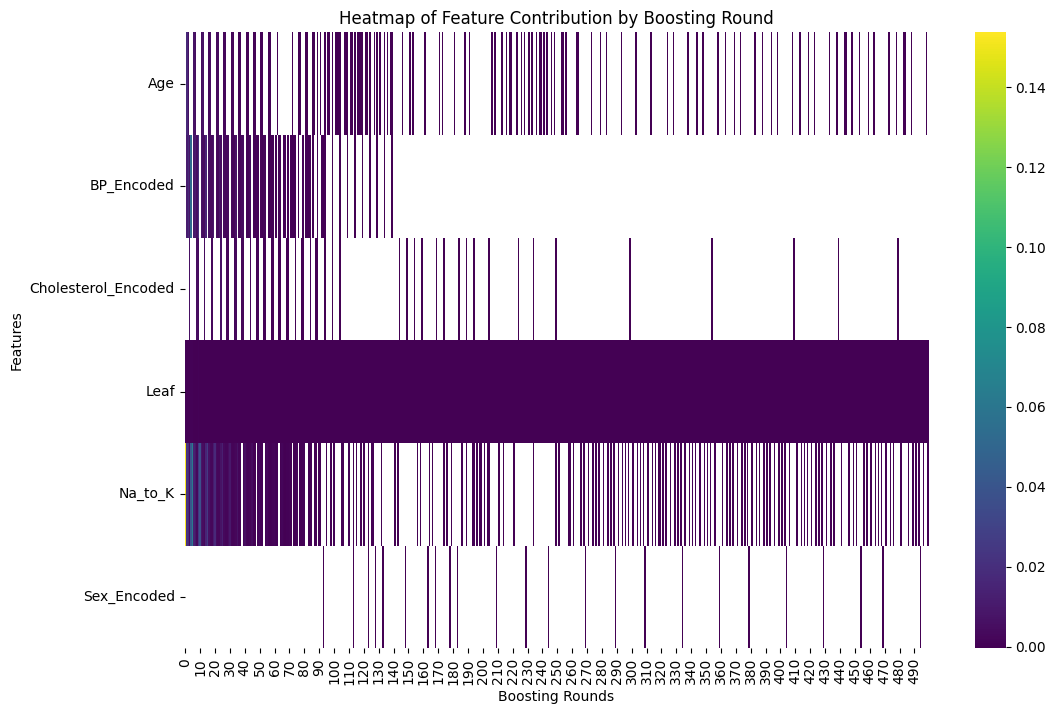

In [15]:
def plot_feature_gain_heatmap(self):
    # Pivot the data to get boosting rounds as columns and features as rows
    heatmap_data = self.plot_data['feature_gain_by_tree_index'].pivot_table(
        index="split_feature", columns="tree_index", values="frac_of_total_split_gain"
    )
    
    # Plot heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data, cmap="viridis", annot=False, cbar=True)
    plt.title("Heatmap of Feature Contribution by Boosting Round")
    plt.xlabel("Boosting Rounds")
    plt.ylabel("Features")
    plt.show()
    
setattr(PlotterBase, 'plot_feature_gain_heatmap', plot_feature_gain_heatmap)

plotter.plot_feature_gain_heatmap()    


## D. Cumulative Contribution Plot

In [16]:
def plot_cumulative_feature_gain(self):
    # Calculate cumulative gain for each feature over boosting rounds
    self.plot_data['feature_gain_by_tree_index']['cumulative_gain'] = self.plot_data['feature_gain_by_tree_index'].groupby('split_feature')['frac_of_total_split_gain'].cumsum()

    # Plot cumulative gain
    fig = px.line(
        data_frame=self.plot_data['feature_gain_by_tree_index'],
        x="tree_index",
        y="cumulative_gain",
        color="split_feature",
        title="Cumulative Contribution of Features to Total Gain",
        labels={"cumulative_gain": "Cumulative Gain"}
    )
    self._customize_plot(fig)
    self._add_deselect_all_button(fig)
    return fig

setattr(PlotterBase, 'plot_cumulative_feature_gain', plot_cumulative_feature_gain)

plotter.plot_cumulative_feature_gain()

## Feature Importance Over Time (Combined with Split Count)

In [17]:
def plot_feature_importance_vs_split_count(self):
    # Access the specific DataFrame inside the dictionary
    df = self.plot_data['feature_gain_by_tree_index']
    
    # Calculate cumulative split count
    df['split_count'] = df.groupby('split_feature')['tree_index'].cumcount() + 1
    
    # Ensure size values are positive and scale them for better visualization
    df['scaled_gain'] = df['frac_of_total_split_gain'].apply(lambda x: max(x, 0.001))

    # Plot feature importance vs split count
    fig = px.scatter(
        data_frame=df,
        x="split_count",
        y="frac_of_total_split_gain",
        color="split_feature",
        size="scaled_gain",
        title="Feature Importance vs Split Count",
        labels={"split_count": "Number of Splits", "frac_of_total_split_gain": "Relative Gain Contribution"}
    )
    
    self._customize_plot(fig)
    self._add_deselect_all_button(fig)
    
    return fig


setattr(PlotterBase, 'plot_feature_importance_vs_split_count', plot_feature_importance_vs_split_count)

plotter.plot_feature_importance_vs_split_count()

## ECDF

Number of features (backwards recursively eliminated) that sum to a percentage of a total model gain

Now we plot the ECDF of cumulative gain attribution by feature. As input we use the `feature_gain_by_tree_index`. In the following:
- __X-axis__: Represents the number of boosting rounds (tree indices) in the model. The model is gradually building trees, and each feature contributes differently to the cumulative gain over time.
- __Y-axis__: Cumulative fraction of total gain contributed by each feature. As the boosting rounds progress, the contribution of each feature to the overall model gain is accumulated, eventually summing to 1 (100%).

Each line corresponds to a feature (e.g., `Age`, `BP_Encoded`, `Cholesterol_Encoded`, etc.) and represents how much cumulative gain that feature has contributed over the number of boosting rounds.

In [18]:
def plot_ecdf_gain_attribution_by_feature(self):
    """
    Plots the ECDF of cumulative gain attribution by feature. 
    This function takes a DataFrame plot_data['feature_gain_by_tree_index'] as input.
    """

    # Ensure the data is cumulative
    self.plot_data['feature_gain_by_tree_index']['cumulative_frac_total_split_gain'] = self.plot_data['feature_gain_by_tree_index'].groupby('split_feature')['frac_of_total_split_gain'].cumsum()

    # Create ECDF plot
    fig = px.ecdf(
        data_frame=self.plot_data['feature_gain_by_tree_index'], 
        x="tree_index", 
        y="cumulative_frac_total_split_gain", 
        color="split_feature",
        title="ECDF: Cumulative Gain Attribution by Feature<br><sup>Ordered by No. of Boosting Rounds</br></sup>",
        labels={"cumulative_frac_total_split_gain": "Cumulative Fraction of Total Split Gain"}
    )
    
    # Apply customizations and add buttons
    self._customize_plot(fig)
    self._add_deselect_all_button(fig)

    return fig

setattr(PlotterBase, 'plot_ecdf_gain_attribution_by_feature', plot_ecdf_gain_attribution_by_feature)

plotter.plot_ecdf_gain_attribution_by_feature()


## Cumulative Features Used By Estimator

In [19]:
def plot_cumulative_features_used_by_estimator(self):
    """
    Plots the cumulative features used by number of estimators.
    This function takes a DataFrame plot_data['tree_depths'] as input.
    """
    
    # Access relevant data
    df = self.plot_data['tree_depths']
    
    # Create figure with cumulative features used by estimators
    fig = go.Figure(go.Scatter(
        x=df['n_estimator'], 
        y=df['n_cumulative_features_used'],
        mode='lines+markers',
        line=dict(color='royalblue', width=2),
        marker=dict(size=6),
        name='Cumulative Features'
    ))
    
    # Get maximum values for reference lines
    y_max = df['n_cumulative_features_used'].max()
    x_max = df['n_estimator'].max()

    # Reference line: "1 New Feature per Boosting Round"
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=x_max, y1=y_max,
        line=dict(dash='dot', color='red'),
        name="1 Feature per Round"
    )
    
    # Greediness metric
    greediness_metric = self.plot_data['feature_greediness'][0]  # Assuming it's defined elsewhere
    user_suggestion = self.plot_data['feature_greediness'][1]
    
    # Adding some useful annotation or warning
    fig.add_annotation(
        text=f"Greediness Metric: {round(greediness_metric, 2)}<br>{user_suggestion}",
        xref="paper", yref="paper",
        x=0.95, y=0.05, showarrow=False,
        bordercolor="black", borderwidth=1, borderpad=4,
        bgcolor="lightyellow", opacity=0.8
    )
    
    # Customize the layout
    fig.update_layout(
        title="Cumulative Features Used by Number of Estimators<br>with Greediness Metric",
        xaxis_title="Number of Estimators (Boosting Rounds)",
        yaxis_title="Cumulative Number of Features Used",
        shapes=[dict(
            type='line',
            x0=0, x1=x_max, y0=0, y1=y_max,
            line=dict(dash='dot', color='green')
        )],
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        )
    )
    
    self._customize_plot(fig)

    return fig

setattr(PlotterBase, 'plot_cumulative_features_used_by_estimator', plot_cumulative_features_used_by_estimator)

plotter.plot_cumulative_features_used_by_estimator()


## New Unique Splits By Feature

In [20]:
def plot_new_unique_splits_by_feature(self):
    """Plots the cumulative number of unique split thresholds by feature over the number of boosting rounds."""
    fig = px.line(self.plot_data['tree_threshold_details'], 
        x = 'tree_index', 
        y = 'n_unique_thresholds_seen', 
        color = 'split_feature', 
        markers = True,
        title = 'Cumulative No. of Unique Thresholds by Estimator<br><sup>tree_index represents One-vs-All (OVA) Tree Index in a multi-class setting.')

    self._customize_plot(fig)
    self._add_deselect_all_button(fig)

    return fig 

setattr(PlotterBase, 'plot_new_unique_splits_by_feature', plot_new_unique_splits_by_feature)

plotter.plot_new_unique_splits_by_feature()

## Expanding Tree Depth By Estimator

In [21]:
def plot_expanding_tree_depth_by_estimator(self):
    """
    Plots the tree depth by number of estimators. 
    This function takes a DataFrame plot_data['tree_depths'] as input.
    """
    fig = go.Figure(go.Scatter(x = self.plot_data['tree_depths']['n_estimator'], 
                               y = self.plot_data['tree_depths']['rolling_avg_max_depth']))
    fig.update_layout(
        title = "Rolling Avg. Tree Depth by n_estimators / boosting rounds",
        xaxis_title = "n_estimators",
        yaxis_title = "rolling_avg_max_depth",
    )

    self._customize_plot(fig)

    return fig  
    
setattr(PlotterBase, 'plot_expanding_tree_depth_by_estimator', plot_expanding_tree_depth_by_estimator)

plotter.plot_expanding_tree_depth_by_estimator()    

---

💚 Thank you for reading 💚

If you have any questions or feedback, feel free to leave a comment 🤔

This notebook is __still in progress__.

Please __UPVOTE__ if you enjoyed this notebook 🙏